In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import natsort
import glob
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import gc

In [2]:
from filter import *

In [3]:
data_folder = 'data'
out_folder = 'output'

In [4]:
probe_df = pd.read_csv(f'{data_folder}/monahan_panel_barcoded_2025_09_18.csv')
hetero_perc_mat = pd.read_pickle(f"{data_folder}/heterodimer_nupack_percent_matrix.pkl")
homo_df = pd.read_csv(f'{data_folder}/monahan_panel_barcoded_NUPACK.csv')

In [5]:
# Read heterodimer percentage matrix:
P      = np.asarray(hetero_perc_mat["matrix"], dtype=float)  # (N,N), percentages in [0,1]
names  = np.asarray(hetero_perc_mat["names"], dtype=object)  # (N,)

In [6]:
# Initialize dataframe to hold filtering results:
filter_raw_df = pd.DataFrame(
    {'hetero_perc_sum': np.asarray(P).sum(axis=0)},
    index=pd.Index(names, name='name')
)

Visualize per probe summed percentage binding to other probes; exclude outliers (beyond dotted line)

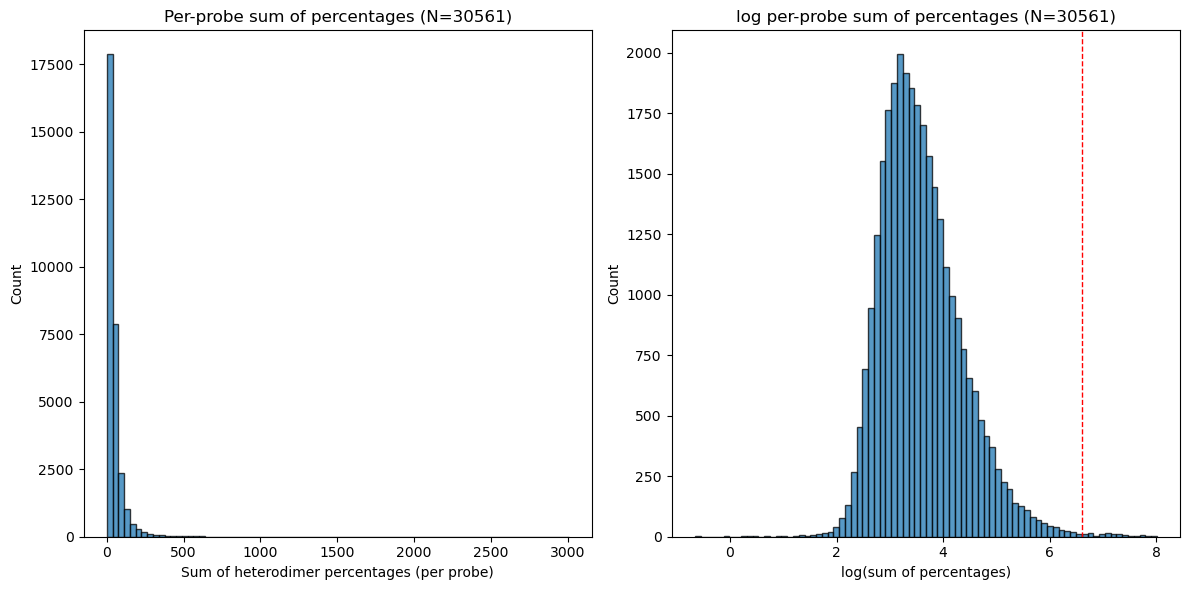

In [7]:
N = P.shape[0]
sum_frac = P.sum(axis=1)  

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Hist sums
ax[0].hist(sum_frac, bins=80, edgecolor="black", alpha=0.75)
ax[0].set_xlabel("Sum of heterodimer percentages (per probe)")
ax[0].set_ylabel("Count")
ax[0].set_title(f"Per-probe sum of percentages (N={N})")

# Hist log-sums
eps = 1e-12
log_sum = np.log(sum_frac + eps)
ax[1].hist(log_sum, bins=80, edgecolor="black", alpha=0.75)
ax[1].set_xlabel("log(sum of percentages)")
ax[1].set_ylabel("Count")
ax[1].set_title(f"log per-probe sum of percentages (N={N})")
ax[1].axvline(6.6, color='red', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.show()


Sainity check: what does the individual binding percent distribution looks like?

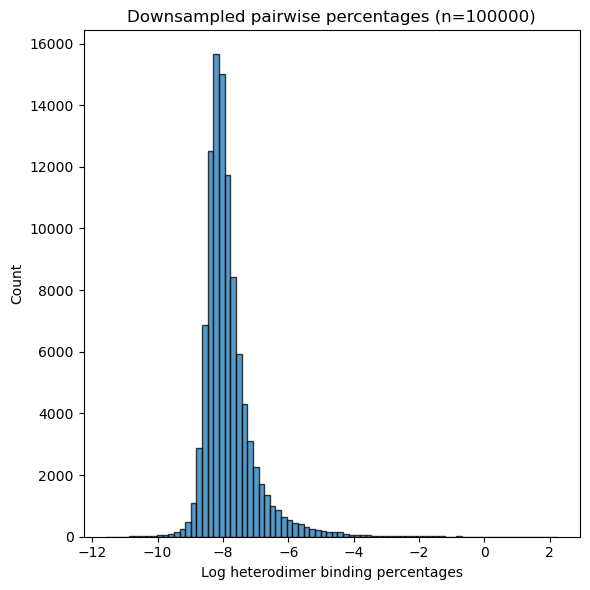

In [8]:
# Downsample hetero-interaction entries:
offdiag = ~np.eye(N, dtype=bool)
ii, jj = np.where(offdiag)

# sample 100000 points:
K = min(100000, ii.size) 
rng = np.random.default_rng(2025)
idx = rng.choice(ii.size, size=K, replace=False)
sample_vals = P[ii[idx], jj[idx]]
log_sample = np.log(sample_vals + eps)

plt.figure(figsize=(6,6))
plt.hist(log_sample, bins=80, edgecolor="black", alpha=0.75)
plt.xlabel("Log heterodimer binding percentages")
plt.ylabel("Count")
plt.title(f"Downsampled pairwise percentages (n={K})")
plt.tight_layout(); plt.show()

In [9]:
# I used trial-and-error to pick remove_frac=0.01:
keep_mask_hetero_offenders, log_df = drop_global_offenders(P, names, remove_frac=0.01)

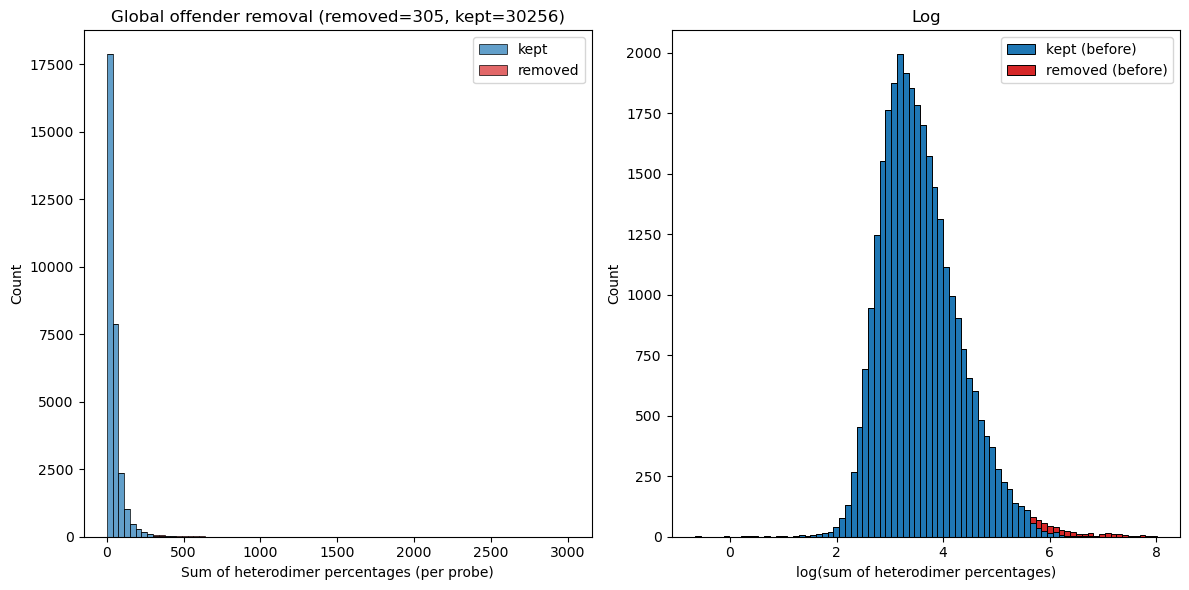

In [10]:
sum_before = sum_frac
sum_after  = sum_frac[keep_mask_hetero_offenders]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist([sum_after, sum_before[~keep_mask_hetero_offenders]],
           bins=80, stacked=True, label=["kept", "removed"],
           edgecolor="black", linewidth=0.7, alpha=0.7, color=["C0","C3"])
ax[0].set_xlabel("Sum of heterodimer percentages (per probe)")
ax[0].legend()
ax[0].set_ylabel("Count")
ax[0].set_title(f"Global offender removal (removed={(~keep_mask_hetero_offenders).sum()}, kept={keep_mask_hetero_offenders.sum()})")
ax[0].legend()

sum_before = P.sum(axis=1)                    # per-probe sums on full matrix
log_before = np.log(sum_before + eps)

log_before_kept    = log_before[keep_mask_hetero_offenders]
log_before_removed = log_before[~keep_mask_hetero_offenders]

ax[1].hist([log_before_kept, log_before_removed],
           bins=80, stacked=True,
           edgecolor="black", linewidth=0.7, 
           label=["kept (before)", "removed (before)"],
           color=["C0","C3"])
ax[1].set_xlabel("log(sum of heterodimer percentages)")
ax[1].set_ylabel("Count")
ax[1].set_title(f"Log")
ax[1].legend()
plt.tight_layout()
plt.show()


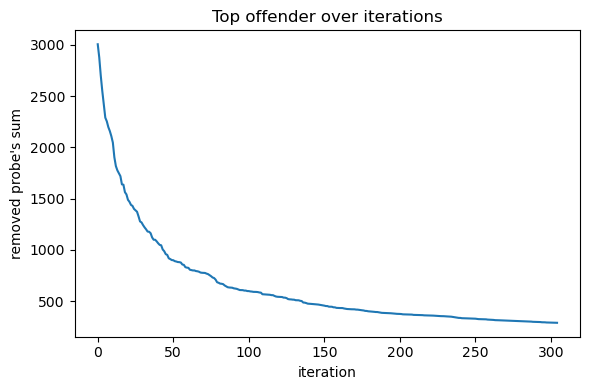

In [11]:
plt.figure(figsize=(6,4))
plt.plot(log_df["iter"], log_df["sum_before"], lw=1.5)
plt.xlabel("iteration")
plt.ylabel("removed probe's sum")
plt.title("Top offender over iterations")
plt.tight_layout(); plt.show()

In [12]:
# free memory
del hetero_perc_mat, P, names, offdiag, ii, jj, log_sample

-----

start working on the per gene filtering

Include homo binding efficiency

In [13]:
# keep only binding fraction columns, rename padlock_name to name
homo_cols = (
    homo_df[['padlock_name', 'half1_any_fraction', 'half2_any_fraction']]
      .rename(columns={'padlock_name': 'name'})
)

# merge binding fraction onto filter_raw_df:
filter_raw_df = filter_raw_df.merge(
    homo_cols,
    on='name',
    how='left',
    validate='m:1'   
)


In [14]:
annot_df  = pd.read_csv(f'{data_folder}/olfr_consensus_cds_3utr_annotations.csv')
blast_df = pd.read_csv(f"{data_folder}/Olfrs_monahan_BLAST_Tm_results_2025_09_18.csv")

In [15]:
# Set the temperature threshold to be 30C, such that we keep considering for the low affinity binding
temp = 30

# Note that some of self binding is also < 37C, but 30 is enough to include them all
self_df_olfr = blast_df[(blast_df.gene == blast_df.blast_target) &
                        (blast_df.ligation_site_missmatch == False) &
                         (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                   (blast_df.subject.str.startswith("Olfr"))]

self_df_taar = blast_df[(blast_df.gene == blast_df.blast_target) &
                        (blast_df.ligation_site_missmatch == False) &
                        (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                   (blast_df.gene.str.startswith("Taar"))]

In [16]:
self_df = pd.concat([self_df_olfr, self_df_taar], ignore_index=True)

In [17]:
self_df['tm_melting_diff'] = abs(self_df.tm_right_melting -self_df.tm_left_melting)

In [18]:
self_df_collapsed = collapse_duplicated(self_df, subject_col="subject", verbose=True)

/Users/xinzheng/Repos/receptor_probe_filtering/filter.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report = g.apply(


Dropped columns: ['sstart', 'send']
Rows before: 47839
Rows after:  30657


/Users/xinzheng/Repos/receptor_probe_filtering/filter.py:126: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby(key_cols, dropna=False, sort=False, group_keys=False)


In [19]:
# keep, per query, the row with the highest (tm_left_NN + tm_right_NN)
_score = self_df_collapsed['tm_left_NN'] + self_df_collapsed['tm_right_NN']
self_df_collapsed = (
    self_df_collapsed
      .assign(_score=_score)
      .sort_values('_score', ascending=False)           # best first
      .drop_duplicates(subset='query', keep='first')    # keep best per query
      .drop(columns='_score')
      .sort_values('query')                             # final sort by query
      .reset_index(drop=True)
)

# count rows after dropping
num_rows = len(self_df_collapsed)
print(num_rows)

30561


In [20]:
cols = (self_df_collapsed[['query', 'tm_melting_diff']].rename(columns={'query': 'name'}))
filter_raw_df = filter_raw_df.merge(cols, on='name', how='left', validate='m:1')

Include low affinity binding

In [21]:
# Now filter off-target hits the ones that have melting temperature  > 30C 
valid_off_df = blast_df[  (blast_df.ligation_site_missmatch == False) &  
                        (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                       (blast_df.blast_target != blast_df.gene) ] 
len(valid_off_df)

58770

In [22]:
# Remove duplicate off-target hits by choosing the one with the highest sum of left right arm melting temperatures
_score = valid_off_df['tm_left_melting'] + valid_off_df['tm_right_melting']

valid_off_df = (
    valid_off_df
      .assign(_score=_score)
      .sort_values('_score', ascending=False)
      .drop_duplicates(subset=['query', 'blast_target'], keep='first')
      .drop(columns='_score')
      .reset_index(drop=True)
)

In [23]:
valid_off_df

,query,subject,percentage identity,length,mismatches,gaps,qstart,qend,sstart,send,...,valid_probe_NN,ligation_site_missmatch,specific,tm_left_melting,tm_right_melting,valid_probe_melting,left_length,right_length,valid_specific_row,valid_non_specific_row
0,padlock_01720,Olfr1427|OTTMUSG00000059439|OTTMUST00000145880,90.000,40,4,0,1,40,639,678,...,False,False,False,54.07,54.63,True,20,20,False,False
1,padlock_24376,ENSMUST00000141187.8,82.051,39,5,2,2,40,4086,4122,...,False,False,False,59.18,48.76,True,19,20,False,False
2,padlock_07780,ENSMUST00000055146.4,82.500,40,7,0,1,40,709,748,...,False,False,False,55.26,52.21,True,20,20,False,False
3,padlock_20649,ENSMUST00000130213.2,92.500,40,3,0,1,40,617,656,...,False,False,False,54.41,52.42,True,20,20,False,False
4,padlock_15029,ENSMUST00000208970.3,87.500,40,5,0,1,40,799,838,...,False,False,False,51.59,54.01,True,20,20,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21087,padlock_13615,ENSMUST00000129271.8,88.462,26,0,2,8,32,2546,2569,...,False,False,False,30.04,30.19,False,13,13,False,False
21088,padlock_10475,Olfr782|OTTMUSG00000056563|OTTMUST00000139698,83.784,37,4,2,5,40,677,712,...,False,False,False,30.20,30.01,False,17,20,False,False
21089,padlock_10475,Olfr804|OTTMUSG00000056621|OTTMUST00000139781,83.784,37,4,2,5,40,911,946,...,False,False,False,30.20,30.01,False,17,20,False,False
21090,padlock_10475,ENSMUST00000222301.2,83.784,37,4,2,5,40,297,332,...,False,False,False,30.20,30.01,False,17,20,False,False


In [24]:
# sum over target for per query in valid_off_df
tm_cols = ['tm_left_melting', 'tm_right_melting']
sums_by_query = (
    valid_off_df[['query'] + tm_cols]
      .fillna({c: 0 for c in tm_cols})
      .groupby('query', as_index=True)[tm_cols]
      .sum()
      .rename(columns={
          'tm_left_melting': 'tm_left_melting_sum',
          'tm_right_melting': 'tm_right_melting_sum'
      })
)

# build summed_temp_df with one row per name in filter_raw_df, preserving 
# order of padlocks by filling no off-target sum with 0
names_in_order = filter_raw_df['name'].drop_duplicates()
summed_temp_df = (
    pd.DataFrame({'name': names_in_order})
      .merge(sums_by_query, how='left', left_on='name', right_index=True)
      .fillna({'tm_left_melting_sum': 0, 'tm_right_melting_sum': 0})
      .reset_index(drop=True)
)


In [25]:
summed_temp_df

,name,tm_left_melting_sum,tm_right_melting_sum
0,padlock_00001,0.00,0.00
1,padlock_00002,32.88,44.04
2,padlock_00003,33.78,44.60
3,padlock_00004,0.00,0.00
4,padlock_00005,0.00,0.00
...,...,...,...
30556,padlock_30557,0.00,0.00
30557,padlock_30558,0.00,0.00
30558,padlock_30559,0.00,0.00
30559,padlock_30560,0.00,0.00


In [26]:
# merge summed temps into filter_raw_df
filter_raw_df = (
    filter_raw_df
      .merge(
          summed_temp_df[['name', 'tm_left_melting_sum', 'tm_right_melting_sum']],
          on='name',
          how='left',
          validate='m:1'
      )
)

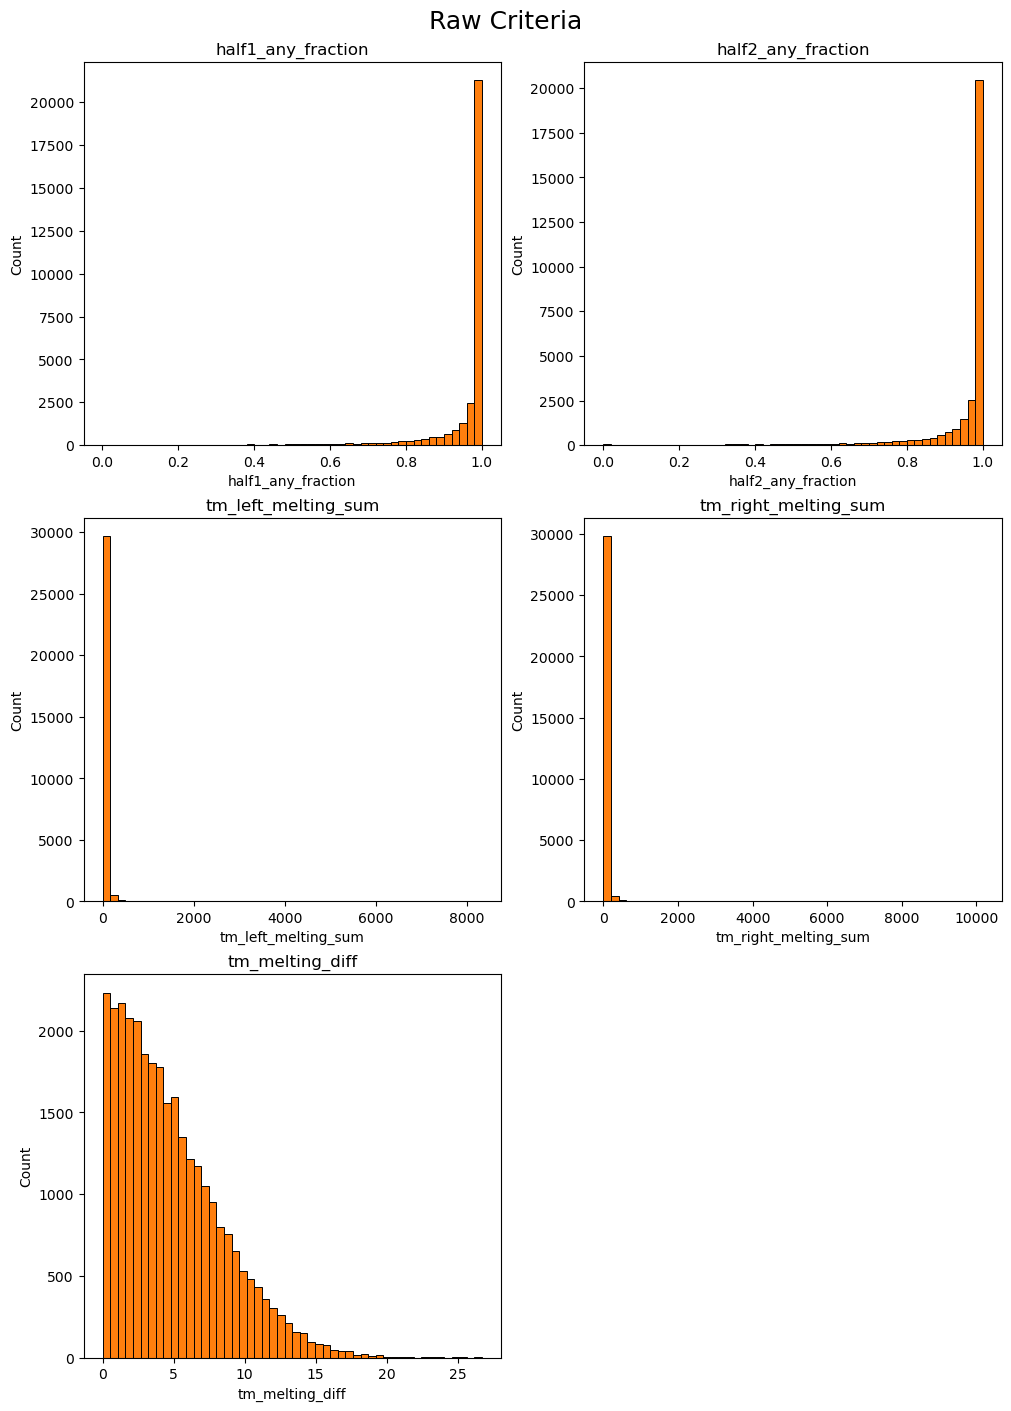

In [27]:
# Columns to visualize
cols = [
    'half1_any_fraction', 'half2_any_fraction',
    'tm_left_melting_sum', 'tm_right_melting_sum',
    'tm_melting_diff'
]

fig, axes = plt.subplots(3, 2, figsize=(10, 14), constrained_layout=True)
axes = axes.ravel()

for ax, col in zip(axes, cols):
    series = pd.to_numeric(filter_raw_df[col], errors='coerce').dropna().to_numpy(float)
    ax.hist(series, bins=50,
            edgecolor="black", linewidth=0.7, 
            color='C1')
    ax.set_title(f"{col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# turn off any unused subplots (if fewer than 6 columns)
for k in range(len(cols), len(axes)):
    axes[k].axis("off")

plt.suptitle("Raw Criteria", fontsize=18)
plt.show()


Turn them into scores, first, combine left and right

In [28]:
# --- binding_combind ---
# take the smaller of the two percentages, to be conservative, clip to [0, 1)
frac_min = np.fmin(filter_raw_df['half1_any_fraction'], filter_raw_df['half2_any_fraction'])
frac_min = frac_min.clip(lower=0, upper=1 - eps)
filter_raw_df['binding_combind'] = -np.log(1 - frac_min)

In [29]:
# --- off_target_combined ---
tm_sum = filter_raw_df['tm_left_melting_sum'] + filter_raw_df['tm_right_melting_sum']
filter_raw_df['off_target_combined'] = np.log(tm_sum + eps)

In [30]:
filter_df= filter_raw_df[['name', 'tm_melting_diff', 'binding_combind', 'off_target_combined']]

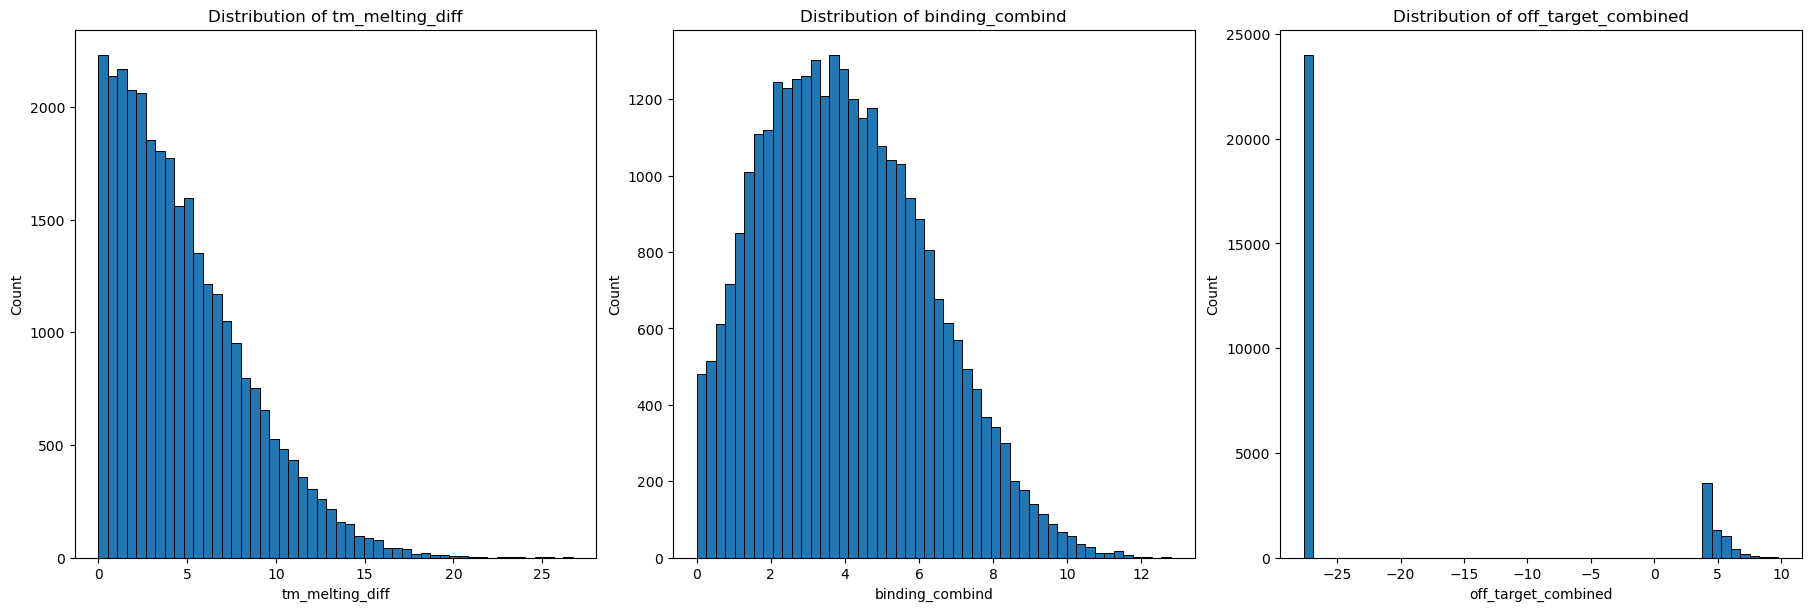

In [31]:
cols = ['tm_melting_diff', 'binding_combind', 'off_target_combined']

series_list = []
for col in cols:
    if col not in filter_df.columns:
        series_list.append(None)
        print(f"Column '{col}' not found; skipping.")
        continue
    s = pd.to_numeric(filter_df[col], errors='coerce').dropna().to_numpy(float)
    series_list.append(s)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, col, s in zip(axes, cols, series_list):
    ax.hist(
        s,
        bins=50,
        edgecolor="black",
        linewidth=0.7,
        color="C0",
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    
plt.show()

In [32]:
# z-scoring:

score_cols = ['tm_melting_diff', 'binding_combind', 'off_target_combined']

for col in score_cols:
    s = filter_df[col]
    std = s.std(ddof=0)
    filter_df[f'{col}_z'] = (s - s.mean()) / std        


/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_5104/2028819127.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df[f'{col}_z'] = (s - s.mean()) / std
/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_5104/2028819127.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df[f'{col}_z'] = (s - s.mean()) / std
/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_5104/2028819127.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

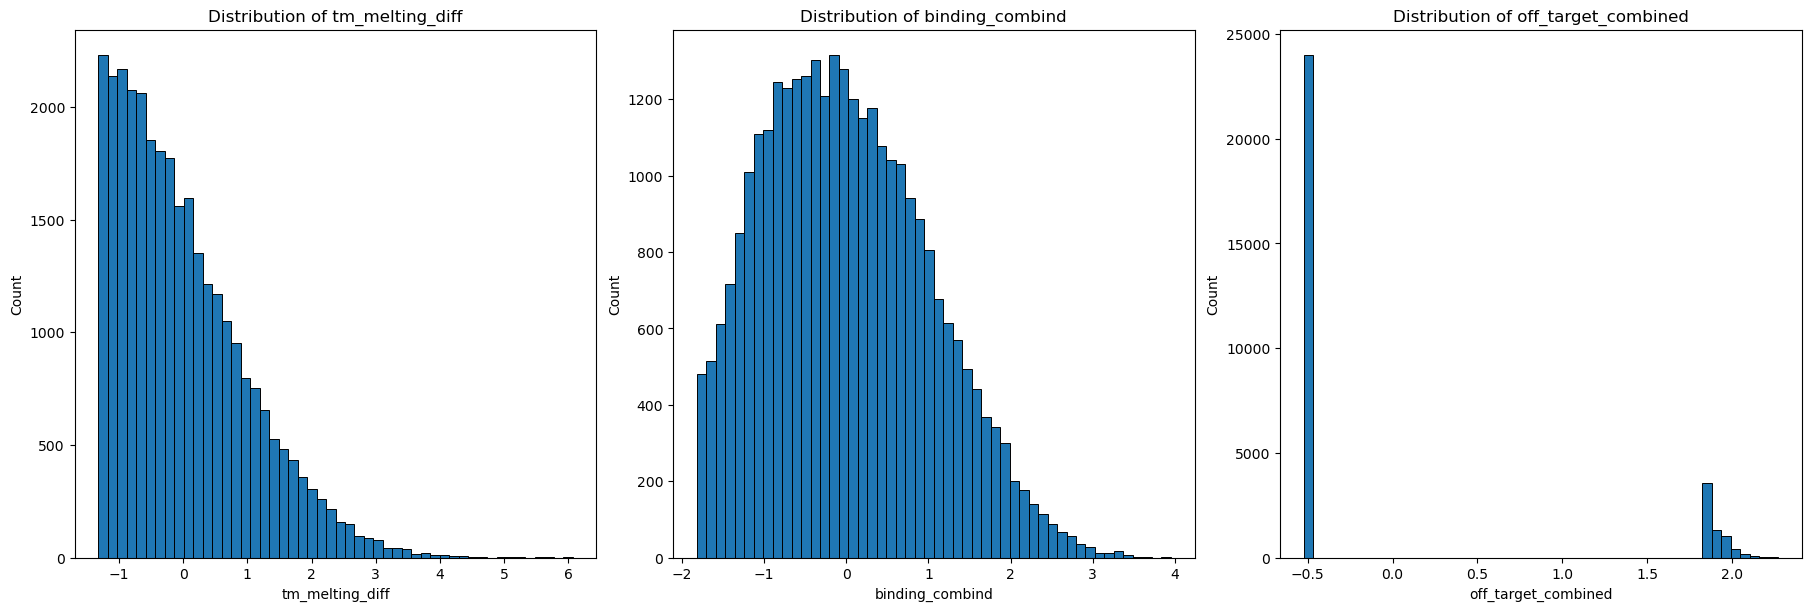

In [33]:
z_cols = ['tm_melting_diff_z', 'binding_combind_z', 'off_target_combined_z']

series_list = []
for col in z_cols:
    if col not in filter_df.columns:
        series_list.append(None)
        print(f"Column '{col}' not found; skipping.")
        continue
    s = pd.to_numeric(filter_df[col], errors='coerce').dropna().to_numpy(float)
    series_list.append(s)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, col, s in zip(axes, cols, series_list):
    ax.hist(
        s,
        bins=50,
        edgecolor="black",
        linewidth=0.7,
        color="C0",
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    
plt.show()

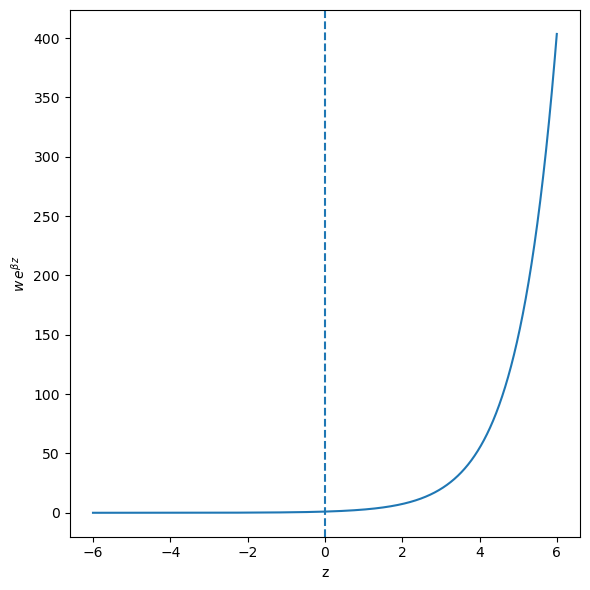

In [34]:
z = np.linspace(-6, 6, 60001)
w = 1
beta = 1
plt.figure(figsize=(6,6))
y = w * np.exp(beta * z)
plt.plot(z, y, label=f"w={w}, β={beta}")
plt.axvline(0, ls="--")
plt.xlabel("z")
plt.ylabel(r"$w\,e^{\beta z}$")

plt.tight_layout()
plt.show()

In [35]:
# columns already in filter_df:
col_dict = {
    "armgap": "tm_melting_diff_z",
    "binding": "binding_combind_z",
    "offtg": "off_target_combined_z",
}

# optional per-metric weights and betas
weights = {"armgap": 1.0, "binding": 1.0, "offtg": 1.0}
betas   = {"armgap": 2.0, "binding": 2.0, "offtg": 2.0}


# compute Boltzmann-style terms and total Z (bigger = worse)
terms = {}
for k, col in col_dict.items():
    z = np.asarray(filter_df[col].to_numpy(float))
    terms[k] = weights[k] * np.exp(betas[k] * z)

filter_df["score_total"] = terms["armgap"] + terms["binding"] + terms["offtg"]


/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_5104/2333025430.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df["score_total"] = terms["armgap"] + terms["binding"] + terms["offtg"]


In [36]:
filter_df['gene'] = probe_df['acronym']

In [37]:
filter_df

,name,tm_melting_diff,binding_combind,off_target_combined,tm_melting_diff_z,binding_combind_z,off_target_combined_z,score_total,gene
0,padlock_00001,0.08,5.418173,-27.631021,-1.297039,0.623090,-0.522637,3.903342,Or7e175
1,padlock_00002,2.47,5.607408,4.342766,-0.636223,0.708420,1.866802,46.233788,Or7e175
2,padlock_00003,1.00,3.623331,4.361569,-1.042666,-0.186250,1.868207,42.760566,Or7e175
3,padlock_00004,3.71,2.975214,-27.631021,-0.293372,-0.478503,-0.522637,1.291772,Or7e175
4,padlock_00005,6.64,2.554520,-27.631021,0.516750,-0.668204,-0.522637,3.425273,Or7e175
...,...,...,...,...,...,...,...,...,...
30556,padlock_30557,12.67,5.160641,-27.631021,2.183999,0.506962,-0.522637,81.993573,Taar6
30557,padlock_30558,5.23,2.146893,-27.631021,0.126896,-0.852014,-0.522637,1.822449,Taar6
30558,padlock_30559,10.67,3.241628,-27.631021,1.631015,-0.358370,-0.522637,26.942386,Taar6
30559,padlock_30560,12.30,1.111141,-27.631021,2.081697,-1.319061,-0.522637,64.712451,Taar6


---
## filtering steps:

### 1. drop the offenders:

In [38]:
gene_wise_filter_df = filter_df.loc[keep_mask_hetero_offenders].copy()
gene_wise_filter_df

,name,tm_melting_diff,binding_combind,off_target_combined,tm_melting_diff_z,binding_combind_z,off_target_combined_z,score_total,gene
0,padlock_00001,0.08,5.418173,-27.631021,-1.297039,0.623090,-0.522637,3.903342,Or7e175
1,padlock_00002,2.47,5.607408,4.342766,-0.636223,0.708420,1.866802,46.233788,Or7e175
2,padlock_00003,1.00,3.623331,4.361569,-1.042666,-0.186250,1.868207,42.760566,Or7e175
3,padlock_00004,3.71,2.975214,-27.631021,-0.293372,-0.478503,-0.522637,1.291772,Or7e175
4,padlock_00005,6.64,2.554520,-27.631021,0.516750,-0.668204,-0.522637,3.425273,Or7e175
...,...,...,...,...,...,...,...,...,...
30556,padlock_30557,12.67,5.160641,-27.631021,2.183999,0.506962,-0.522637,81.993573,Taar6
30557,padlock_30558,5.23,2.146893,-27.631021,0.126896,-0.852014,-0.522637,1.822449,Taar6
30558,padlock_30559,10.67,3.241628,-27.631021,1.631015,-0.358370,-0.522637,26.942386,Taar6
30559,padlock_30560,12.30,1.111141,-27.631021,2.081697,-1.319061,-0.522637,64.712451,Taar6


## 2. keep 10 best combined scores:

In [ ]:
gene_wise_filter_df = gene_wise_filter_df.rename(columns={'name': 'padlock_name'})

all_names = filter_df["name"].to_numpy()  # original order

df_sub = gene_wise_filter_df              # already subset by prior global drop
prior_mask = keep_mask_hetero_offenders  

out_df, kept_df, dropped_df, keep_mask_full = keep_top_per_gene(
    df_sub,
    score_col="score_total",
    gene_col="gene",
    name_col="padlock_name",              
    max_per_gene=10,
    add_overall_ranks=True,
    all_names=all_names,
    prior_keep_mask=prior_mask,
    return_full_mask=True,
)

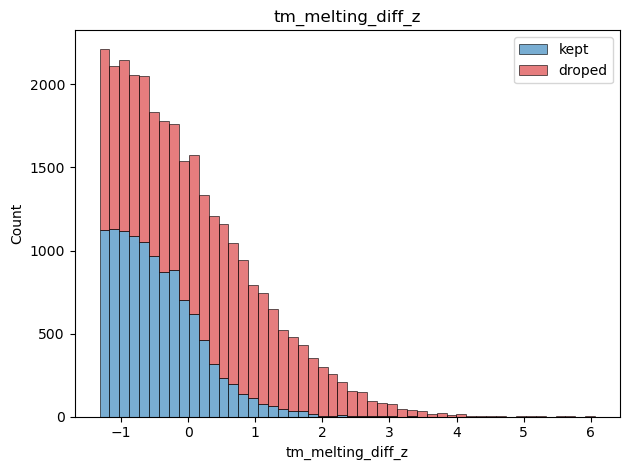

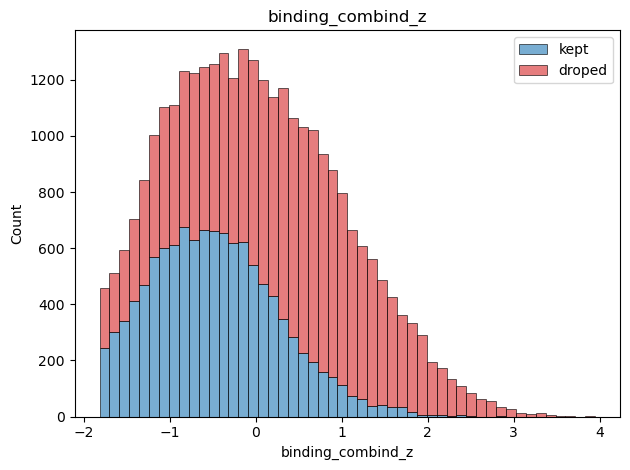

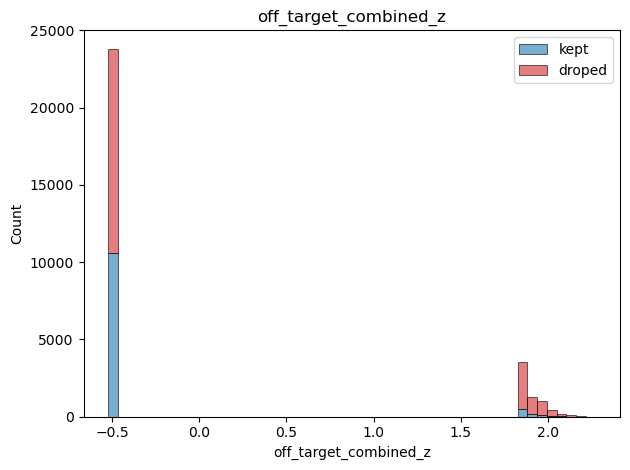

In [40]:
for col in z_cols:

    plt.figure()
    
    x_keep = out_df.loc[out_df["keep"],  col]
    x_drop = out_df.loc[~out_df["keep"], col]

    plt.hist(
        [x_keep, x_drop],
        bins=50,
        stacked=True,
        edgecolor="black",
        linewidth=0.7,
        alpha=0.6,
        label=["kept", "droped"],
        color=["C0", "C3"],
    )
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"{col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [41]:
probe_df

,acronym,target,Tm,startpos,endpos,padlock,transcript_region,gene_name,padlock_name,barcode,RT primer,name,hairpin_dg_kcalmol,homodimer_dg_kcalmol,best_heterodimer_dg_kcalmol,best_heterodimer_partner
0,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,68.223082,37,76,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Olfr869,padlock_00001,CACTATCGTC,ACTGTGAGACAACTGGTAGA,oligo_0,-5.2,-12.5,-24.6,oligo_13653
1,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,68.120975,97,136,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Olfr869,padlock_00002,CACTATCGTC,AAAACAGCACAAGTAGGAAA,oligo_1,-4.9,-9.3,-22.3,oligo_13653
2,Or7e175,TGCATGTATGGATAGTATGCTTCTGACTGTAATGGCCTAT,67.964276,363,402,TTCTGACTGTAATGGCCTATATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Olfr869,padlock_00003,CACTATCGTC,ATAGGCCATTACAGTCAGAA,oligo_2,-3.7,-9.9,-22.2,oligo_13653
3,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,67.061987,529,568,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Olfr869,padlock_00004,CACTATCGTC,TAGAGATTTCCATGCCACTG,oligo_3,-5.5,-10.2,-24.1,oligo_13653
4,Or7e175,TATTGTGATCCTTCCCAACTTCTTAATCTTAACTGTTCTG,64.822847,574,613,TCTTAATCTTAACTGTTCTGATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Olfr869,padlock_00005,CACTATCGTC,CAGAACAGTTAAGATTAAGA,oligo_4,-3.6,-10.1,-22.6,oligo_13653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30556,Taar6,AACCCTGGGGATTACCGTGGTAGCATTCATGATATCATGG,68.464670,774,813,TAGCATTCATGATATCATGGATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Taar6,padlock_30557,CATCGCCTTT,CCATGATATCATGAATGCTA,oligo_30556,-5.4,-13.4,-21.8,oligo_13653
30557,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,67.027758,819,858,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Taar6,padlock_30558,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,oligo_30557,-5.8,-13.4,-26.8,oligo_13653
30558,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,68.672690,909,948,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Taar6,padlock_30559,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,oligo_30558,-2.8,-8.4,-26.5,oligo_13653
30559,Taar6,TAAGAAAGCTATTAAGGTTATTATGAGTGGCCAGGTGTTC,65.797484,954,993,TTATGAGTGGCCAGGTGTTCATCGTCGGACTGTAGAACTCTGAACC...,['CDS'],Taar6,padlock_30560,CATCGCCTTT,GAACACCTGGCCACTCATAA,oligo_30559,-5.8,-15.9,-22.3,oligo_8544
